# Alzheimers Multiclass-Classification

# Introduction
Transfer learning using a convolution neural net (CNN) was used to classify brain MRIs into normal, very-mild, mild and moderate alzheimer classes. The data consists of 6,400 images split into train and test sets. 

# Methodology
The following steps were taken to prepare the images for analysis, select a base model, and tune hyperparameters. Several helper functions were built to simplify tasks for reuse throughout the analysis

+ **Data Preparation**
    + Import libraries, set constants and seeds
    + Resample the train dataset into train/validation
    + Preprocess images for analysis
    + View sample images
+ **Build helper functions for model building & evaluation**
    + Plot training metrics
    + Freeze all or some layers in the base model
    + Build and compile CNN models
+ **Select a base model**
    + Train a simple transfer model using DenseNet121, InceptionV3, Xception and ResNet101
    + Select the base with the best AUC
+ **Tune the model**
    + Add capacity to the base model
    + Tune hyperparameters using keras tuner
    + Add data augmentation
+ **Train the final model & evaluate performance**


# Data Preparation
## Install and Import Libraries
There are a number of libraries required for this analysis which are installed/imported below. Of note, keras-tuner is used to perform grid-search to find optimal hyperparameters and split-folders is used to split folders of images into test, train and validate folders with stratification for classes

In [1]:
pip install split-folders      # split-folders

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import Libraries
import numpy as np 
import pandas as pd 
import time
import itertools

# file system libraries
import os
import os.path
from   os import path
import shutil

# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# splits train folders into train/validation with stratification
import splitfolders  

# Images, Plotting
from skimage import io
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# tensorflow - CNNs
import tensorflow as tf
import kerastuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend, models, layers, Sequential
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121,InceptionV3, Xception, ResNet101
from kerastuner.tuners import Hyperband

## Set Constants and Seeds
Define the paths to the images and set seeds for reproducibility

In [3]:
# Constants
FOLDERS     = ['train','val','test']
DIR_INPUT   = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'
DIR_WORK    = './'
DIR_MODELS  = os.path.join(DIR_WORK,'models')
DIR_TRAIN   = os.path.join(DIR_WORK,'train')
DIR_VAL     = os.path.join(DIR_WORK,'val')
DIR_TEST    = os.path.join(DIR_WORK,'test')
CLASS_LIST  = ['MildDememted','ModerateDemented','NonDememted','VeryMildDemented']


# Set seeds for reproducibility 
SEED        = 1985
tf.random.set_seed(SEED)
np.random.seed(SEED)

## Determine the Number of Images for each class
The dataset provided is split into train and test batches consisting of 4 classes.  The function below loops through each folder and displays the number of images of each class

In [4]:
def images_by_class(path,folders):
    """
    Loop through the path/folders count the number and proportions of each class
    """
    
    # accumulators
    normal,verymild,mild,moderate =0,0,0,0
    
    # print header
    msg = '{:8} {:8} {:11} {:7} {:9} {:9} {:11} {:8} {:8}'.format('folder','normal','verymild','mild','moderate',
                                                        'normal %','verymild %','mild %','moderate %')
    print(msg)  
    print("-"*len(msg))
    
    for folder in FOLDERS:
        for dirname,_, filenames in os.walk(os.path.join(path,folder)):
            for file in filenames:
                if "NonDemented" in dirname:
                    normal+=1
                if "VeryMildDemented" in dirname:
                    verymild+=1
                if 'MildDemented' in dirname:
                    mild+=1
                if 'ModerateDemented' in dirname:
                    moderate+=1
                    
        # calculate total and percentages            
        total = normal+verymild+mild+moderate
        if total >0:
            n  = round(normal/total,2)*100
            vm = round(verymild/total,2)*100
            m  = round(mild/total,2)*100
            mo =round(moderate/total,2)*100
        else:
            n,vm,m,mo = 0,0,0,0
        
        print("{:6} {:8} {:10} {:7} {:11} {:8} {:10} {:8} {:12}".format(folder,normal,verymild,mild,moderate,n,vm,m,mo))
        normal,verymild,mild,moderate =0,0,0,0

# Images by class in the input directory
images_by_class(DIR_INPUT,FOLDERS) 

folder   normal   verymild    mild    moderate  normal %  verymild %  mild %   moderate %
-----------------------------------------------------------------------------------------
train      2560       1792    2509          52     37.0       26.0     36.0          1.0
val           0          0       0           0        0          0        0            0
test        640        448     627          12     37.0       26.0     36.0          1.0


## Resample the train dataset into train/validation
The functions below copy the images from the train folders in the input directory and randomly splits them into train/validate with equal proportions in each class and saves them to the working directory

In [5]:
# create a new directory if it doesn't exist
def create_dir(dir_path,folder,verbose=True):
    """
    Create the dir_path/folder if it doesn't already exist
    """
    msg = ""
    folder_path = os.path.join(dir_path,folder)
    
    if not path.exists(folder_path):
        try:
            os.mkdir(folder_path)
            msg = folder_path + ' created'
        except OSError as err:
            print('Error creating folder:{} with error:{}'.format(folder_path,err))
    if verbose:
        print(msg)
        
    return folder_path

# create model directory
create_dir(DIR_WORK,'models',True)

./models created


'./models'

In [6]:
def resample_train_val_images(input_dir,working_dir,seed=SEED,split = (0.80,0.20)):
    """
    Resample the train images into train/val by the ratios given in split
    """
    # get paths
    dir_test   = os.path.join(input_dir,'test')
    dir_train  = os.path.join(input_dir,'train')
    

    # remove existing files/folders
    for folder in FOLDERS:
        if path.exists(os.path.join(working_dir,folder)):
            shutil.rmtree(os.path.join(working_dir,folder))

            
    # copy the test directory to working
    shutil.copytree(dir_test, os.path.join(working_dir,'test'))
        

    # resample
    splitfolders.ratio(dir_train, working_dir, seed=seed, ratio=split) 
        
    # print image summary by folder
    print("\n Images By Class After Resampling")
    print("-"*67)
    images_by_class(working_dir,FOLDERS)
    
    
resample_train_val_images(DIR_INPUT,DIR_WORK)

Copying files: 5121 files [00:41, 123.23 files/s]



 Images By Class After Resampling
-------------------------------------------------------------------
folder   normal   verymild    mild    moderate  normal %  verymild %  mild %   moderate %
-----------------------------------------------------------------------------------------
train      2048       1433    2006          41     37.0       26.0     36.0          1.0
val         512        359     503          11     37.0       26.0     36.0          1.0
test        640        448     627          12     37.0       26.0     36.0          1.0


# Preprocess Images for analysis
Image generators from TensorFlow were used to feed images directly to our model from the image directories. The images were grayscale and needed to be converted to color to use with pre-trained models.

## Image Transformations

+ scale images
+ convert to RGB
+ set seed for reproducibility

In [7]:

IMG_SIZE = [176,208]
BATCH_SIZE = 32

# Scale Images
train_images = ImageDataGenerator(rescale  = 1./255)
val_images   = ImageDataGenerator(rescale  = 1./255)
test_images  = ImageDataGenerator(rescale  = 1./255)


# Image Generators
# train images: 4098
train_gen =train_images.flow_from_directory(
    DIR_TRAIN,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',          # convert to rgb
    seed        = SEED 
)

# validation images: 1023
val_gen = val_images.flow_from_directory(
    DIR_VAL,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',         # convert to rgb
    seed        = SEED
)

# test images:1279
test_gen = test_images.flow_from_directory(
    DIR_TEST,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',         # convert to rgb
    seed        = SEED,
    shuffle     = False
)

# Training and Validation Steps
steps_per_epoch  = train_gen.n // train_gen.batch_size
print("steps per epoch:{}".format(steps_per_epoch))

Found 4095 images belonging to 4 classes.
Found 1026 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
steps per epoch:127


## View Images with lables
View sample images from the generators to ensure the transformations make sense. This function displays the processed train, test, or validation images from the image generators. It will display actual and predicted labels (if provided)

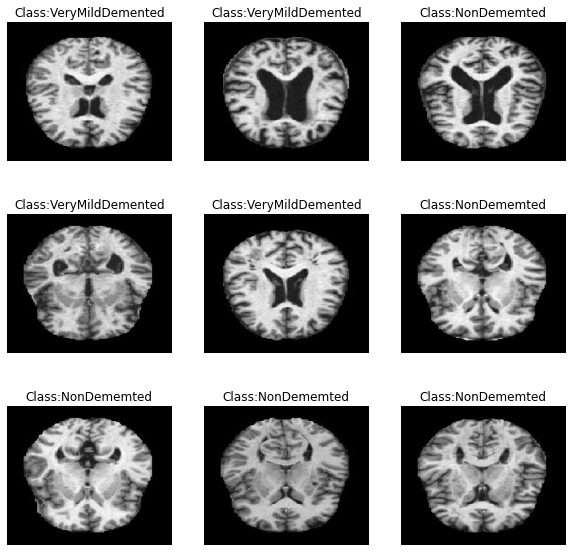

In [8]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASS_LIST))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[i])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_gen)

# Model Building and Evaluation Functions
Several functions were built to assist with model building, training, and evaluation

## Function:Plot Training Metrics
This function was used throughout the analysis to plot training metrics. It plots loss by epochs, AUC by epochs, and the four-class confusion matrix with the training AUC metric. AUC was chosen as the performance metric instead of accuracy due to the class imbalance in the training images

In [9]:
def plot_training_metrics(train_hist,model,test_gen,y_actual,y_pred,classes):
    """
    Input: trained model history, model, test image generator, actual and predicted labels, class list
    Output: Plots loss vs epochs, accuracy vs epochs, confusion matrix
    """
    
    # Evaluate the results:
    test_loss, test_metric = model.evaluate(test_gen,verbose = False)
    results       = round(test_metric,2)*100 
    results_title ="\n Model AUC on Test Data:{}%".format(results)
    print(results_title.format(results))
    print(len(results_title) * "-")
    
    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))

    # extract data from training history for plotting
    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    epochs          = range(1, len(history_dict['auc']) + 1)

    # get the min loss and max accuracy for plotting
    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)
    
    # create plots
    plt.subplots(figsize=(12,4))
    
    # plot loss by epochs
    plt.subplot(1,3,1)
    plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'cornflowerblue', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
    plt.legend()

    # plot accuracy by epochs
    plt.subplot(1,3,2)
    plt.plot(epochs, auc_values, 'bo',label = 'Training AUC')
    plt.plot(epochs, val_auc_values, 'cornflowerblue', label = 'Validation AUC')
    plt.plot(epochs,[results/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test AUC')
    plt.title('Validation AUC by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.axhline(y=max_auc,color='darkslategray', linestyle='--')
    plt.legend()

    
    # calculate Confusion Matrix
    cm = confusion_matrix(y_actual, y_pred)

    # create confusion matrix plot
    plt.subplot(1,3,3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title("Confusion Matrix \n AUC:{}%".format(results))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


## Function: Freeze/Un-Freeze Model Layers
Transfer learning requires us to freeze some of the model layers to reuse pre-trained model weights. This function will freeze all, some or none of the layers in a base model. The trainable_layers parameter is used to freeze 'all' base weights to reuse all pre-trained weights, 'none' to forget all training weights, or 'some' to freeze a subset of weights. To freeze only some of the weights you need to provide the layer name and block numbers

+ trainable_layers: 'all' => keep all pretrained weights
+ trainable_layers: 'none'=> retrain all layers
+ trainable_layers: 'some'=> must provide the layer name,ranges to freeze

In [10]:
def freeze_layers(base,conv_num="conv5",block_num=1,max_block_num=16,trainable_layers='some'):
    """
    Input: A base transferable model,the layer name, the block number, the max number of blocks
           The layer name, block number and max of blocks only works with DenseNet121
    Output:Sets all layers to trainable from conv#_block_num to conv#_max_block_num
    
    """
    if trainable_layers=='none':
        base.trainable = False
        print("No Layers Trainable: Using Base Model Weights")
    if trainable_layers=='all':
        base.trainable =True
        print("All Layers Trainable: Base Model will be fully trained")
    
    if trainable_layers=='some':
        
        print("Some Layers of the Model will be Trainable:")
        print("---------------------------------------------")
        
        # set all layers to not trainable
        base.trainable = False

        # loop through all layers from conv#_block# and set to true
        print('layer','\t\t\t','trainable')
        for block in range(block_num,max_block_num+1):
            for layer in conv_base.layers:
                if block>=block_num:
                    if conv_num +"_block"+str(block) in layer.name:
                        layer.trainable = True
                        print(layer.name,'\t',layer.trainable)
                    
                    

## Function: Build & Compile a Transfer Model
This function takes a base model and training parameters and returns a compiled model.

In [11]:
# function to build the model
def build_transfer_model(conv_base,dropout,dense_node,learn_rate,metric):
    """
    Build and compile a transfer learning model
    Input: a base model, dropout rate, the number of filters in the dense node, 
           the learning rate and performance metrics
    Output: A compiled CNN model
    """
    
    # clear previous run
    backend.clear_session()
    
    # build the model
    model = Sequential()
    model.add(conv_base)
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_node,activation='relu'))
    model.add(Dense(4,activation='softmax'))


    # complile the model
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
        loss      = 'categorical_crossentropy', 
        metrics   = metric )
    
    model.summary()
    return model

# Select a Base Model
To select a base model for transfer learning a simple model was trained using DenseNet121, InceptionV3, Xception and ResNet101 with a single dense layer for classification. All pre-trained weights were frozen and the AUC for the training set was calculated. The image dataset is unbalanced with unequal examples of classes. Accuracy would be biased towards the highest frequency class, so AUC was selected as an alternative model performance metric.

## Base Model: Transfer Learning
+ freeze the weights in the base model
+ add a single dense layer for classification
+ add callbacks for early stopping based on validation AUC
+ use AUC as the performance metric
+ train the model with each base models: DenseNet121, VGG19, InceptionV3, Xception,ResNet101
+ select the best base based on AUC

In [12]:
# training parameters
EPOCHS        = 15
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 5,restore_best_weights=True)
callbacks     = [early_stoping]
metrics       = [tf.keras.metrics.AUC(name='auc')]

87916544/87910968 [==============================] - 1s 0us/step
No Layers Trainable: Using Base Model Weights
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 5, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 4, 5, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 5, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               20972032  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total param

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        mild       0.38      0.27      0.32       179
    moderate       0.00      0.00      0.00        12
      normal       0.57      0.93      0.71       640
   very-mild       0.67      0.17      0.27       448

    accuracy                           0.56      1279
   macro avg       0.41      0.34      0.32      1279
weighted avg       0.57      0.56      0.49      1279



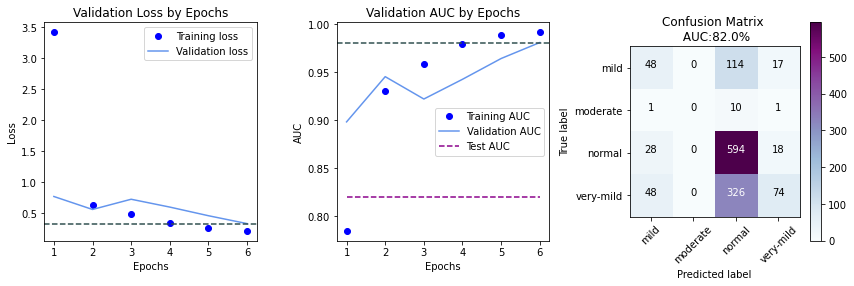

Total Time:1.91


In [13]:
# Train Model: Base Model
# get base
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.4,dense_node =512,learn_rate=0.001,metric=metrics)


# train
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        = callbacks  # early stopping 
)

# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot training metrics
plot_training_metrics(history,model,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

# Save the Model
model.save(os.path.join(DIR_MODELS,'base_model'))

# display runtime
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))



# Tune Model Hyperparameters
InceptionV3 had the highest AUC on the test dataset and was selected as the base model (only InceptionV3 is shown for brevity). A number of additional steps were taken to improve the test AUC


## Base Model (Inceptionv3) + Additional Capacity
To increase the capacity of the model additional convolution layers were added along with dropout and batch normalization for regularization. The build transfer model function was adjusted to add the additional layers. 

In [14]:
# function to build the model
# add an additional conv layer with dropout and batch normalization
def build_transfer_model(conv_base,dropout,conv_nodes,dense_node,learn_rate,metric):
    """
    Build and compile a transfer learning model
    """
    
    # clear previous run
    backend.clear_session()
    
    # build the model
    model = Sequential()
    model.add(conv_base)
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Conv2D(conv_nodes,3,padding='same',activation='relu'))
    model.add(Conv2D(conv_nodes,3,padding='same',activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout +0.10))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_node,activation='relu'))
    model.add(Dense(4,activation='softmax'))


    # complile the model
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
        loss      = 'categorical_crossentropy', 
        metrics   = metric )
    
    model.summary()
    return model


No Layers Trainable: Using Base Model Weights
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 5, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 4, 5, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 5, 2048)        8192      
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 5, 1024)        18875392  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 5, 1024)        9438208   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 1024)        0         
_________________________________________________________________
dropout_1 

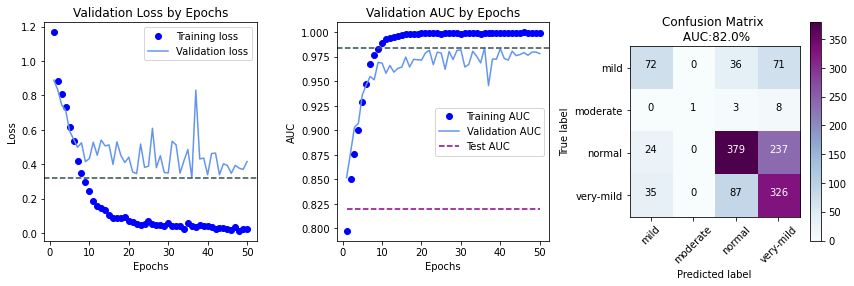

Total Time:10.37


In [15]:
# Base Model: Plus Additional Capacity
# training parameters
EPOCHS        = 50
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 10,restore_best_weights=True)
callbacks     = [early_stoping]
metrics       = [tf.keras.metrics.AUC(name='auc')]



# Train Model: Base + Additional Capacity
# get base
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.001,metric=metrics)


# train
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2
)

# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history,model,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

# Save Model
model.save(os.path.join(DIR_MODELS,'model_added_capacity'))

# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

## Hyperparameter Search using keras tuner
The tuner package from keras was used to search for optimal hyperparameters for dropout rate, learning rate and the filter size for the convolution and dense layers. The resulting parameters produced the model with the best performance. **Note-** the code was run onnce then commented out to save GPU.  This step takes several hours of compute time.

+ dropout rates: 0.50, 0.60
+ learning rate: 1e-3
+ convolution layer:1024
+ dense layer:1024

In [16]:
# Tune Hyperparameters  (not run for brevity)
# define Hyperparameters 
# hp                   = kt.HyperParameters()
# DROP_RATES           = [0.30,0.40,0.50]
# CONV_NODES           = [512,1024,2048]
# DENSE_NODES          = [512,1024,2048]
# LEARN_RATE           = [0.001,0.0001]
    

# # get base
# CONV_BASE = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# # unfreeze layers for training
# freeze_layers(CONV_BASE,trainable_layers='none')

# # function to build the model
# def build_model(hp):
    
#     # clear previous run
#     backend.clear_session()

#     # Searchable parameters
#     dropout    = hp.Choice('dropout',DROP_RATES)
#     conv_nodes = hp.Choice('conv_node',CONV_NODES)
#     dense_node = hp.Choice("dense_node",DENSE_NODES)
#     learn_rate = hp.Choice("learn_rate",LEARN_RATE)
   
    
#     # build the model
#     model = Sequential()
#     model.add(CONV_BASE)
#     model.add(Dropout(dropout))
#     model.add(BatchNormalization())

#     model.add(Conv2D(conv_nodes,3,padding='same',activation='relu'))
#     model.add(Conv2D(conv_nodes,3,padding='same',activation='relu'))
#     model.add(MaxPooling2D())
#     model.add(Dropout(dropout +0.10))
#     model.add(BatchNormalization())

#     model.add(Flatten())
#     model.add(Dense(dense_node,activation='relu'))
#     model.add(Dense(4,activation='softmax'))


#     # complile the model
#     model.compile(
#         optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
#         loss      = 'categorical_crossentropy', 
#         metrics   = ['accuracy'] )
#     return model

# tuner = Hyperband(
#     build_model,
#     objective = 'val_accuracy', 
#     max_epochs = 10,
#     directory = 'tune_hyperband',
#     project_name = 'tune_hyperband',
#     overwrite = True
# )

# # Hyperparameter Tuning
# tuner.search(train_gen,
#              epochs=10,
#              verbose = False,
#              validation_data=val_gen
#             )

# # get the best model
# best_model =tuner.get_best_models(num_models=1)[0]

# # show the optimal hyperparameters
# tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

## Data Augmentation
The training plots show that the model is overfitting early in the epochs. Data augmentation was added to help the model generalize to novel data. Subtle transitions to the train images were added to the train image generator. Sample augmented images are shown below

Found 4095 images belonging to 4 classes.


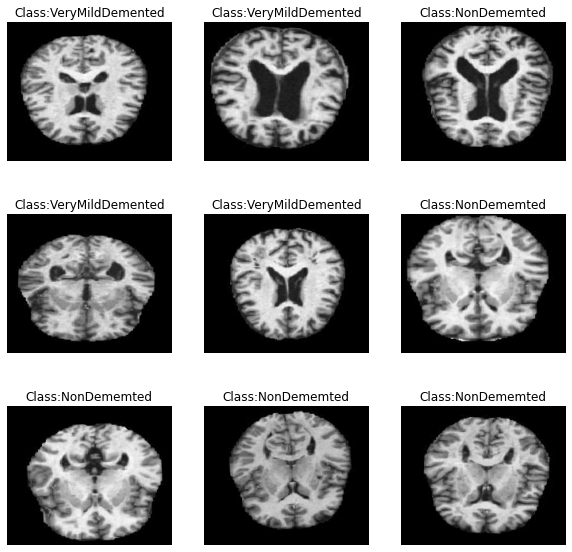

In [17]:
# Data Augmentation on training images
train_images = ImageDataGenerator(rescale            = 1./255,
                                  rotation_range     = 5,
                                  zoom_range         = 0.10,
                                  width_shift_range  =0.05,
                                  height_shift_range =0.05)

# train image generator
train_gen =train_images.flow_from_directory(
    DIR_TRAIN,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',          
    seed        = SEED 
)

show_images(train_gen)

## Base Model (InceptionV3) + Optimized Parameters + Data Augmentation
The model was re-trained with the optimized hyperparameters using data augmentation.  The training was slowed down using a reduced schedule for learn-rate, early stopping was removed and the epochs were set to 150 to give the model as much time to train as possible without overfitting

No Layers Trainable: Using Base Model Weights
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 5, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 4, 5, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 5, 2048)        8192      
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 5, 1024)        18875392  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 5, 1024)        9438208   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 1024)        0         
_________________________________________________________________
dropout_1 

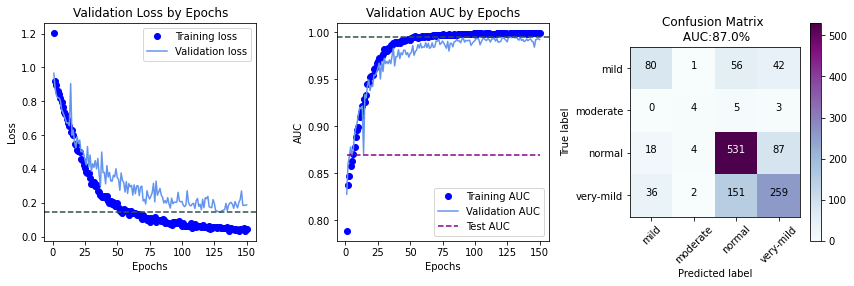

Total Time:99.08 mins


In [18]:
# training parameters
EPOCHS        = 150
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 15,restore_best_weights=True)
reduce_lr     = ReduceLROnPlateau(monitor='val_auc',factor=0.9, patience=15, min_lr=1e-20, verbose=1, cooldown=3)
callbacks     = [reduce_lr]
metrics       = [tf.keras.metrics.AUC(name='auc')]



# Train Model: Base + Optimized Hyperparameters + Data Augmentation
# get base
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.001,metric=metrics)


# train
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        =callbacks 
)

# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history,model,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

# Save Model
model.save(os.path.join(DIR_MODELS,'model_added_capacity'))

# time
toc = time.perf_counter()
print("Total Time:{} mins".format(round((toc-tic)/60,2)))

# View Images and Labels
We can view examples of actual and predicted labels with the show_images function by providing the predicted labels

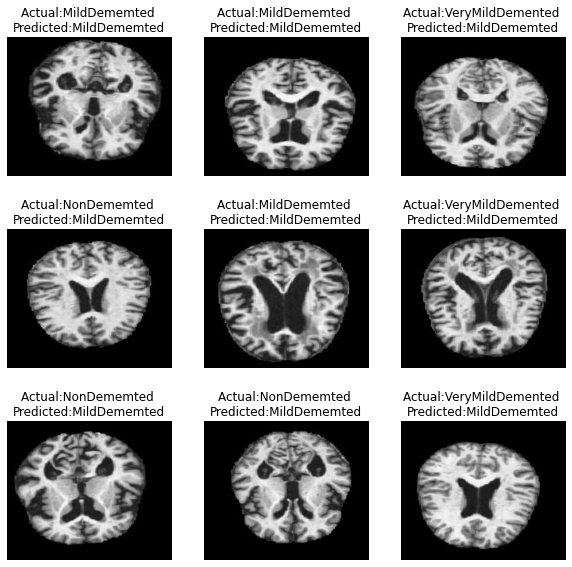

In [19]:
# show_images and labels
show_images(train_gen,y_pred)

# Conclusions
We can see from the confusion matrix that the model does best at identifying normal and very-mild MRIs and poorest identifying moderate cases. This makes sense given the small number of moderate examples in the dataset. Adding model capacity, searching for optimal hyperparmaters and adding data augmentation resulted better performance on the test dataset.